(week11:earthcare_xarray)=
# Convert earthcare to xarray

This notebook reads in an earthcare hdf5 file and converts it to an xarray dataset by adding
dimensions, coordinates and variables.
We store the height of the first ray, the time and the along-track distance as coordinates, and the longitude,
latitude, reflectivity in dbZ and doppler velocity as variables.

The first 1000 km of the data have a height glitch, so in the second part of the notebook we show how to
remove the bad data by cropping on the distance coordinate, rewrite the coordinates with the new height, distance
coordinates, and write the dataset out to a netcdf file.

## Installation

- Download a case folder from the satdata/earthcare folder on our
[gdrive folder](https://drive.google.com/drive/folders/1-D6y9MlE8LZRLZg-qRCxPZSgar8kGjBT?usp=drive_link)

- fetch and rebase from upstream/main to get this notebook in week11

In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import pyproj
from matplotlib import pyplot as plt
import datetime
import pytz
import pyproj

## Find the case files

Organize them in a dictionary keyed by the case name, which
is at the start of the relative file path.  pathlib has a function that
finds the relative path, and also can break the folder path into 
its various parts

In [2]:
data_dir = Path().home() / 'repos/a301_extras/satdata/earthcare'
radar_filepaths = list(data_dir.glob("**/*.h5"))
filepaths=dict()
for filepath in radar_filepaths:
    relpath = filepath.relative_to(data_dir)
    casename = relpath.parts[0]
    filepaths[casename]=filepath
relpath

PosixPath('case 17/ECA_JXCA_CPR_NOM_1B_20250216T190020Z_20250216T222300Z_04105D.h5')

### This functions sorts the cases by case number

In [3]:
def sort_keys(the_case):
    #
    # the case number starts after 'case' at position 4
    #
    number = the_case[4:]
    #
    # return case number as an integer so it will sort
    # correctly
    #
    return int(number)

### Pick case 4

In [4]:
sorted_keys = list(filepaths.keys())
sorted_keys.sort(key=sort_keys)
casenum = 'case 17'

## Get coordinates

The  three functions below calculator vectors of height, time and distance that
can be used as coordinates for axis labeling, and as indexes for
selecting/cropping values.

In [5]:
def get_binheight(the_bins, index=0):
    """
    select one of the the radar bin heights and fill in missing data with
    estimated values.  By default we'll
    take index=0, i.e. the bin heights for the first pulse

    Parameters
    ----------

    """
    the_bins = the_bins[:,index].data
    diff_bins = np.diff(the_bins)
    del_y = float(np.nanmean(diff_bins))
    new_y = [float(the_bins[0])]
    for count,old_y in enumerate(the_bins[1:]):
        #
        # found a nan to be replaced
        #
        if np.isnan(old_y):
            new_y.append(float(new_y[count]) + float(del_y))
        else:
            new_y.append(float(old_y))
    return np.array(new_y)

def find_times(filepath):
    """
    times are stored as seconds after Jan 1, 2000 UTC
    use the datetime.timedelta function to increment from
    that start time

    
    """
    cpr_meta = xr.open_dataset(filepath, engine='h5netcdf', group='/ScienceData/Geo',
                           decode_times=False, phony_dims='access')
    times = cpr_meta['profileTime'].data
    start_time = datetime.datetime(2000,1,1,0,0,0)
    the_times =[start_time + datetime.timedelta(seconds=item) for item in times]
    #
    # netcdf doesn't understand timezones so document the UTC timezone in
    # the metadata
    #
    return the_times

great_circle=pyproj.Geod(ellps='WGS84')
meters2km = 1.e-3
def calc_distance(lonvec,latvec):
    """
    the pyproj.Geod object calculates the lat, lon between
    2 points on a great circle, and the inverse calculates
    the great circle distance between 2 lot/lon points
    """
    distance=[0]
    startlon,startlat = lonvec[0],latvec[0]
    for lon,lat in zip(lonvec[1:],latvec[1:]):
        azi12,azi21,step= great_circle.inv(startlon,startlat,lon,lat)
        distance.append(distance[-1] + step)
        startlon,startlat = lon, lat
    distance=np.array(distance)*meters2km
    return distance

In [6]:
def ec_to_xarray(ec_filepath):
    """
    open an earthcare h5 file and read the times, latitude, longitude, radar reflectivity
    and the dopple velocity. Save this as an xarray dataset with coordinates and dimensions
    """
    cpr_data = xr.open_dataset(ec_filepath, engine='h5netcdf', group='/ScienceData/Data',
                                decode_times=False,  phony_dims='access')
    cpr_data = cpr_data.rename_dims({'phony_dim_0':'distance','phony_dim_1': 'height'})
    cpr_meta = xr.open_dataset(ec_filepath, engine='h5netcdf', group='/ScienceData/Geo',
                               decode_times=False, phony_dims='access')
    cpr_meta = cpr_meta.rename_dims({'phony_dim_0':'distance','phony_dim_1': 'height'})
    lonvec = cpr_meta['longitude']
    latvec = cpr_meta['latitude']
    distance = calc_distance(lonvec.data, latvec.data)
    the_times = find_times(ec_filepath)
    binHeights = cpr_meta.binHeight[...].T
    heights = get_binheight(binHeights,0)
    coords = dict(height=("height",heights),
              distance = ("distance",distance))
    velocity = cpr_data['dopplerVelocity'].T
    radar = cpr_data['radarReflectivityFactor'].T
    dbZ = 10*np.log10(radar)
    attrs=dict(history = f"written by ec_to_xarray on {str(datetime.datetime.now())}",
               timezone="UTC")
    var_dict = dict(dbZ = dbZ , velocity=velocity,binHeights=binHeights,
                   longitude=lonvec, latitude=latvec,time=the_times)
    ds_earthcare = xr.Dataset(data_vars=var_dict,
        coords=coords,attrs=attrs)
    return ds_earthcare

## Create the dataset

Note that the dataset `radar_ds` has dimensions: (height, time, distance),
coordinates: (height, time and distance) and indices: (height, time, and distance).
They all have the same names but they serve different purposes.  The dimensions
show the shape of the data, the coordinates allow for different axis labels,
and the indices can be used for selecting the data, as demonstrated  below.

### call ec_to_xarray

In [7]:
filepaths[casenum]
radar_ds = ec_to_xarray(filepaths[casenum])
radar_ds

/Users/jalena/opt/miniconda3/envs/a301/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/jalena/opt/miniconda3/envs/a301/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


<xarray.Dataset> Size: 26MB
Dimensions:     (height: 218, distance: 9944, time: 9944)
Coordinates:
  * height      (height) float64 2kB 1.623e+04 1.613e+04 ... -5.453e+03
  * distance    (distance) float64 80kB 0.0 0.5001 1.0 ... 5.171e+03 5.172e+03
  * time        (time) datetime64[ns] 80kB 2025-02-16T19:00:23.101428 ... 202...
Data variables:
    dbZ         (height, distance) float32 9MB -49.03 -55.17 -38.68 ... nan nan
    velocity    (height, distance) float32 9MB ...
    binHeights  (height, distance) float32 9MB ...
    longitude   (distance) float64 80kB -58.28 -58.28 -58.28 ... -75.59 -75.59
    latitude    (distance) float64 80kB 67.62 67.61 67.61 ... 22.38 22.38 22.37
Attributes:
    history:   written by ec_to_xarray on 2025-03-28 10:30:11.892184
    timezone:  UTC

### Plot the radar reflectivity

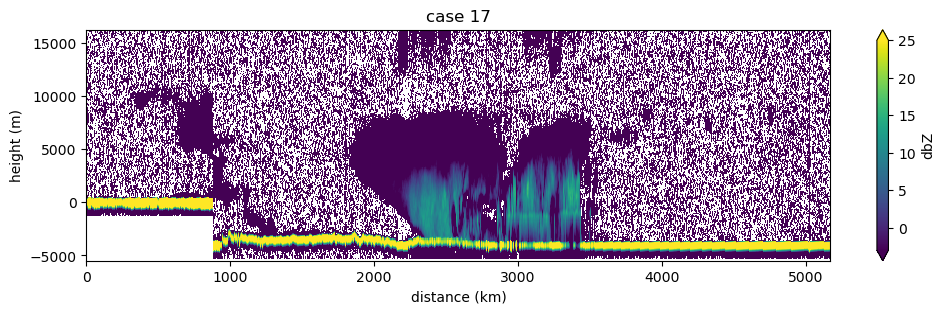

In [8]:
fig, ax = plt.subplots(1,1,figsize=(12,3))
radar_ds['dbZ'].plot(ax = ax, x="distance",y="height",vmin=-3,vmax=25);
ax.set_xlabel("distance (km)")
ax.set_ylabel("height (m)")
ax.set_title(casenum);

## Data cleaning

there's some data loss in the upper atmosphere for the first 1000 km. When those data values appear at 1000 km
it causes an abrupt change in the bin heights.  If we really cared about the first 1000 km, we could split the
dataset to keep both regions. Instead let's just remove that data by cropping the first 1000 km.

### First find the new index for the start

The line below finds the index closest to 1000 km, which is index 1924. We want to use this to select
our new set of heights, instead of the height values at index 0.  np.argmin returns the index of the
distance vector that has the smallest absolute difference from 1000.

In [9]:
new_index = np.argmin(np.abs(radar_ds.distance.data - 1000)) ## Useful way to find the nearest 
# integer index to a floating point number
new_index

np.int64(1925)

### Replace the height coordinates with the value at index 1924

This function will overwrite the height coordinate with the
new value using `assign_coords`

In [10]:
def set_new_height(ds,target_index):
    """
    replace the height coordinate with a new height
    """
    height_array = ds['binHeights']
    bin_height = get_binheight(height_array,target_index)
    ds = ds.assign_coords({'height': bin_height})
    return ds
    

In [11]:
radar_ds = set_new_height(radar_ds,new_index)

### Plot with new height coordinate

Now that we're using the heights at 1000 km, the surface is at z=0 starting at 1000 km


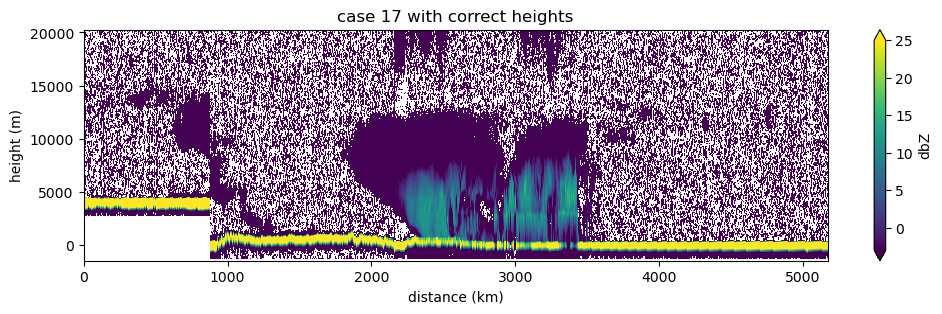

In [12]:
fig, ax = plt.subplots(1,1,figsize=(12,3))
radar_ds['dbZ'].plot(ax = ax, x="distance",y="height",vmin=-3,vmax=25);
ax.set_xlabel("distance (km)")
ax.set_ylabel("height (m)")
ax.set_title(f"{casenum} with correct heights");

### Crop first 1000 km

Next remove the first 1000 km using the `where` function

In [13]:
radar_ds = radar_ds.where(radar_ds.coords['distance'] > 1000.,drop=True) # where the coords are > 1000, drop the data.

### Cropped plot - original x axis

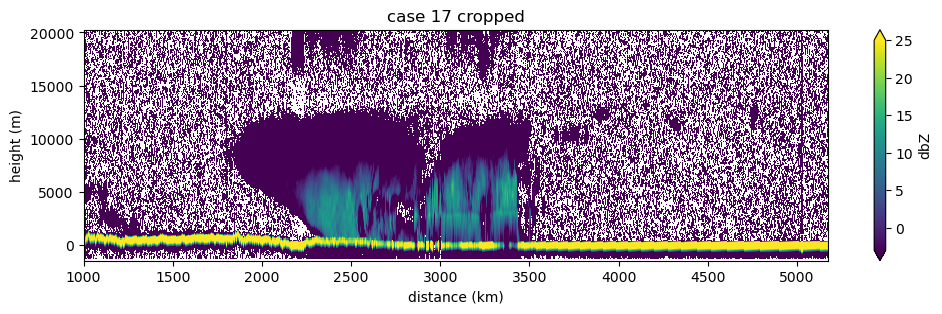

In [15]:
fig, ax = plt.subplots(1,1,figsize=(12,3))
radar_ds['dbZ'].plot(ax = ax, x="distance",y="height",vmin=-3,vmax=25);
ax.set_xlabel("distance (km)")
ax.set_ylabel("height (m)")
ax.set_title(f"{casenum} cropped"); ## but now the x-coords are wrong! Fix this...

### rewrite the distance coordinate

Finally, make the new distance start from 0

In [16]:
new_distance = radar_ds.coords['distance'] - radar_ds.coords['distance'][0]
radar_ds = radar_ds.assign_coords({'distance': new_distance})

### Cropped plot -- new x axis

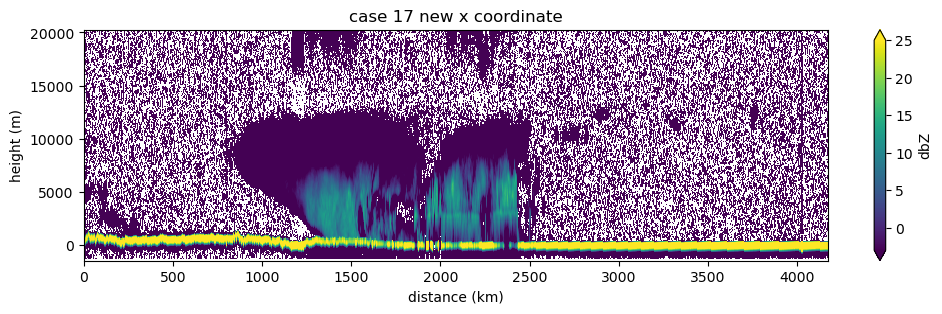

In [17]:
fig, ax = plt.subplots(1,1,figsize=(12,3))
radar_ds['dbZ'].plot(ax = ax, x="distance",y="height",vmin=-3,vmax=25);
ax.set_xlabel("distance (km)")
ax.set_ylabel("height (m)")
ax.set_title(f"{casenum} new x coordinate");

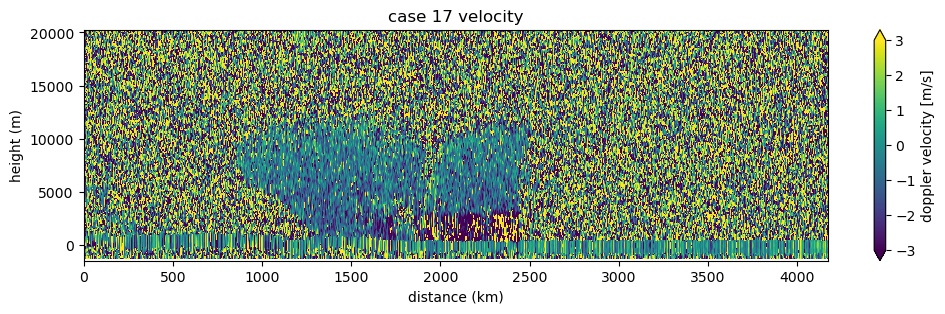

In [18]:
fig, ax = plt.subplots(1,1,figsize=(12,3))
radar_ds['velocity'].plot(ax = ax, x="distance",y="height",vmin=-3,vmax=3);
ax.set_xlabel("distance (km)")
ax.set_ylabel("height (m)")
ax.set_title(f"{casenum} velocity");

## Save the dataset to netcdf

### convert datetimes to numpy.datetime64 objects

the netcdf writer doesn't like python datetimes, but can handle numpy datetimes, so convert times to
[numpy datetime64](https://numpy.org/doc/stable/reference/arrays.datetime.html).

In [22]:
new_times = [np.datetime64(item) for item in radar_ds.coords['time'].data] ## taking datetimes one at a time and turning them into numpy datetime 64, and assigning those to the time coordinate.
radar_ds = radar_ds.assign_coords({'time': new_times})

In [23]:
filename = f"week11_{casenum}_radar.nc"

In [24]:
radar_ds.to_netcdf(f"week11_{casenum}_radar.nc")

#### Read it back in to check

In [25]:
test_ds = xr.open_dataset(filename,decode_times=True)

In [26]:
test_ds

<xarray.Dataset> Size: 21MB
Dimensions:     (height: 218, distance: 8019, time: 9944)
Coordinates:
  * height      (height) float64 2kB 2.021e+04 2.011e+04 ... -1.474e+03
  * distance    (distance) float64 64kB 0.0 0.7459 1.248 ... 4.171e+03 4.172e+03
  * time        (time) datetime64[ns] 80kB 2025-02-16T19:00:23.101428 ... 202...
Data variables:
    dbZ         (height, distance) float32 7MB ...
    velocity    (height, distance) float32 7MB ...
    binHeights  (height, distance) float32 7MB ...
    longitude   (distance) float64 64kB ...
    latitude    (distance) float64 64kB ...
Attributes:
    history:   written by ec_to_xarray on 2025-03-28 10:30:11.892184
    timezone:  UTC